<center>
<img src="logo.png" height="900"> 
</center>


# Максимально правдоподобная домашка

В этом задании мы с вами отточим метод максимального правдоподобия.

In [1]:
import numpy as np
import pandas as pd

from scipy import stats
from scipy.optimize import minimize

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

## Упражнение 1 (Разминка)

__а)__ Пусть $X \sim Exp(0.05)$. Сгенерируйте из этого распределения выборку размера $1000$. У метода `rvs` используйте `random_state=42` 

Обратите внимание, что `stats.expon` принимает в качестве параметра `scale` значение $\frac{1}{\lambda}$, а $0.05$ это именно $\lambda$.

In [ ]:
import numpy as np
from scipy import stats

np.random.seed(42)
x = stats.expon.rvs(scale=1/0.05, size=1000)

assert np.abs(19.45 - np.mean(x)) < 0.01

In [3]:
assert np.abs(19.45 - np.mean(x)) < 0.01

__б)__ Выпишите логарифмическую функцию правдоподобия на бумажке. Затем вбейте её в python.

In [10]:
def lnL(theta, x):
    return -np.sum(np.log(theta) - theta * x)
    

In [11]:
assert np.abs(lnL(4, x) - 76414.1814) < 1e-4

# несколько похожих скрытых тестов

__в)__ Оцените значение параметра $\lambda$ по сгенерированной выборке `x`. Аккуратнее выбирайте точку для инициализации параметра. 

In [12]:
from scipy.optimize import minimize

# Инициализация параметра
theta_init = 1
res = minimize(lnL, theta_init, args=(x,), bounds=[(1e-5, None)])


In [13]:
assert np.abs(res.x[0] - 0.0514) < 1e-4

# несколько похожих скрытых тестов

__г)__ Постройте график для функции правдоподобия. По оси $x$ отложите значения $\lambda$, по оси $y$ логарифм правдоподобия. Отметьте на картинке точку оптимума. 

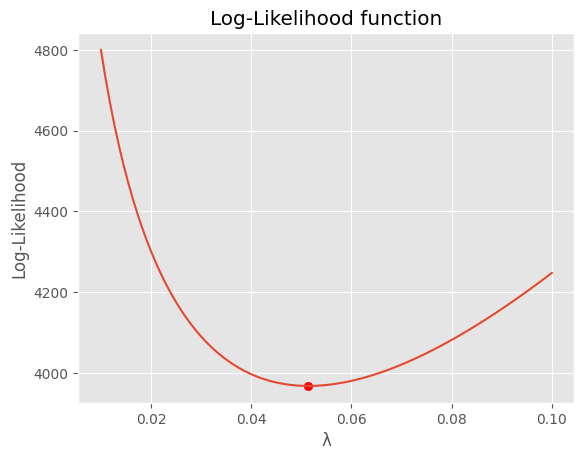

In [14]:
lambda_vals = np.linspace(0.01, 0.1, 100)
lnL_vals = np.array([lnL(l, x) for l in lambda_vals])

# Построение графика
import matplotlib.pyplot as plt

plt.plot(lambda_vals, lnL_vals)
plt.xlabel('λ')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood function')
plt.scatter(res.x, lnL(res.x, x), color='red')  # Точка оптимума
plt.show()

__д)__ Постройте для параметра $\lambda$ асимптотический $80\%$ доверительный интервал. 

In [15]:
alpha = 0.8
z = stats.norm.ppf(1 - (1 - alpha) / 2)

left = res.x - z / np.sqrt(len(x))
right = res.x + z / np.sqrt(len(x))

In [18]:
assert np.abs(z - 1.2815) < 1e-4

# несколько похожих скрытых тестов

__е)__ Проверите на уровне значимости $1\%$ тестом отношения правдоподобия гипотезу о том, что $\lambda = 0.05$. 

In [19]:
lnL_un = lnL(res.x, x)
lnL_r = lnL(0.05, x)

# наблюдаемое значение статистики
LR_obs = 2 * (lnL_un - lnL_r)

# критическое значение
LR_cr = stats.chi2.ppf(0.99, 1)

In [20]:
assert np.abs(lnL_un - 3967.8531) < 1e-4

# несколько похожих скрытых тестов

Справились? Значит вас ничто не может остановить реализовать подобный пайплайн для более сложной ситуации. Убедитесь в этом сами, решив задачку про «Челленджер».

## Упражнение 2 (Логистическая регрессия)

В этом упражнении мы оценим методом максимального правдоподобия логистическую регрессию.

$28$ января $1986$ года космический шатл «Челленджер» взорвался при взлёте. Семь астронавтов, находившихся на борту, погибли. В ходе расследования причин катастрофы основной версией была неполадка с резиновыми уплотнительными кольцами в соединении с ракетными ускорителями. Для $23$ предшествовавших катастрофе полётов «Челленджера» известны температура воздуха и появление повреждений хотя бы у одного из уплотнительных колец.

In [21]:
df = pd.read_csv('challenger.csv', sep=',')
print(df.shape)
df.head()

(23, 3)


,Date,Temperature,Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
3,01/11/1982,68,0
4,04/04/1983,67,0


__а)__ Постройте на графиках гистограмму для распределения температуры $(Temperature)$ в ситуациях, когда хотябы одно кольцо было повреждено $(Incident = 1)$ и в ситуациях, когда ни одного повреждения не было $(Incident = 0)$. 

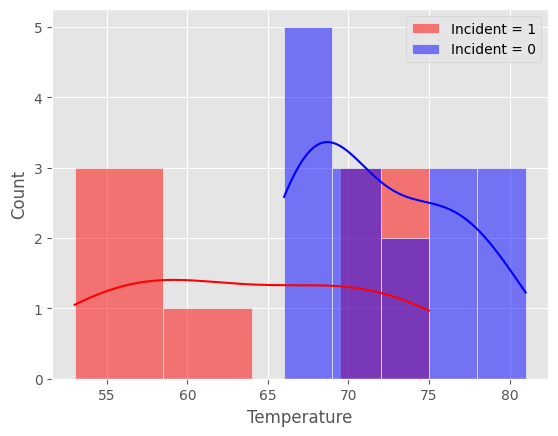

(63.714285714285715, 72.125)

In [22]:
df = pd.read_csv('challenger.csv', sep=',')
sns.histplot(df[df['Incident'] == 1]['Temperature'], kde=True, color='red', label='Incident = 1')
sns.histplot(df[df['Incident'] == 0]['Temperature'], kde=True, color='blue', label='Incident = 0')
plt.legend()
plt.show()

df[df['Incident'] == 1].Temperature.mean(), df[df['Incident'] == 0].Temperature.mean()

In [23]:
df[df['Incident'] == 1].Temperature.mean(), df[df['Incident'] == 0].Temperature.mean()

(63.714285714285715, 72.125)

__б)__ Судя по всему, между температурой и вероятностью поломки есть взаимосвязь. Пусть вероятность поломки зависит от температуры экспоненциально:
    
$$
P(Incident = 1) = \frac{e^{\alpha + \beta \cdot t}}{1 + e^{\alpha + \beta \cdot t}} = \frac{1}{1 + e^{-1\cdot(\alpha + \beta \cdot t)}} 
$$
    
Выведите функцию правдоподобия и задачу для оптимизации поиска коэффициентов $\alpha$ и  $\beta$ на бумажке, а затем вбейте её в python. 

In [24]:
def lnL(theta, data):
    a, b = theta
    
    # your code here
    p = 1 / (1 + np.exp(-(a + b * data['Temperature'])))
    return - np.sum(data['Incident'] * np.log(p) + (1 - data['Incident']) * np.log(1 - p))

In [25]:
assert np.abs(lnL([4, 0.2], df) - 294.8) < 1e-4

# несколько похожих скрытых тестов

__в)__ Оцените параметры $\alpha$ и $\beta$ с помощью метода максимального правдоподобия.

In [26]:
theta_init = [0, 0]
res = minimize(lnL, theta_init, args=(df,))

In [28]:
assert np.abs(res.fun - 10.1576) < 1e-4

# несколько похожих скрытых тестов

__г)__ С помощью теста отношения правдоподобий на уровне значимости $5\%$ проверьте гипотезу о том, что $\alpha = \beta = 0$.

In [34]:
lnL_un = lnL(res.x, df)
lnL_r = lnL(theta_init, df)

LR_obs = 2 * (lnL_r - lnL_un)
LR_crit = stats.chi2.ppf(0.95, 2) 


In [33]:
assert np.abs(lnL_un - 10.1576) < 1e-4

# несколько похожих скрытых тестов

__д)__ В день катастрофы температура уплотнителя была $31$ градус по Фарингейту. Предскажите с помощью построенной модели вероятность катастрофы (для этого подставьте в формулу поиска вероятности получившиеся оценки и температуру).

In [ ]:
xnew = 31
alpha, beta = res.x
p_hat = 1 / (1 + np.exp(-(alpha + beta * xnew)))

In [ ]:
assert np.abs(p_hat - 0.9996) < 1e-4

# несколько похожих скрытых тестов

Только что мы с вами оценили логистическую регрессию. На самом деле функцию потерь, которую обычно используют для оценки логистической регрессии (logloss) можно получить из метода максимального правдоподобия. Об этом мы поговорим на следующей неделе нашего курса. 

__е)__ А сейчас, давайте сделаем финальный штрих и оценим ту же самую моделю с помощью пакета `statsmodels`.

In [ ]:
import statsmodels.formula.api as smf

model = smf.logit(data=df, formula='Incident ~ 1 + Temperature').fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.441635
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Incident   No. Observations:                   23
Model:                          Logit   Df Residuals:                       21
Method:                           MLE   Df Model:                            1
Date:                Sun, 08 Dec 2024   Pseudo R-squ.:                  0.2813
Time:                        18:24:12   Log-Likelihood:                -10.158
converged:                       True   LL-Null:                       -14.134
Covariance Type:            nonrobust   LLR p-value:                  0.004804
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      15.0429      7.379      2.039      0.041       0.581      29.505
Temperature    -0.2322      0.108     -2.145      0.032      -0.444      -0.020
===============================================================================
"""

Посмотрев на протокол, получившийся в результате оценивания модели ответьте на вопросы: 

- Чему равноо значение логарифма правдоподобия? Запишите это значение в `logLik`
- Чему равна оценка константы $\alpha$? Запишите это значение в `alph`
- По свойствам метода максимального правдоподобия $\hat{\beta} \sim N(\beta, \hat{\sigma}^2_{\beta})$, чему равно значение $\hat{\sigma}_{\beta}$? Запишите это значение в `std_beta`
- Чему равно p-значение для гипотезы $H_0: \beta = 0$? Запишите это значение в `pval_beta`
- Отвергается ли гипотеза $H_0: \beta = 0$ на $5\%$ уровне значимости? Если да, запишите в `is_h` значение `False`

In [45]:
logLik = round(model.llf, 3)
alph = round(model.params[0], 3)
std_beta = round(model.bse[1], 3)
pval_beta = round(model.pvalues[1], 3)

C:\Users\ziiat\AppData\Local\Temp\ipykernel_13772\1609419864.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alph = round(model.params[0], 3)
C:\Users\ziiat\AppData\Local\Temp\ipykernel_13772\1609419864.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_beta = round(model.bse[1], 3)
C:\Users\ziiat\AppData\Local\Temp\ipykernel_13772\1609419864.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pval_beta = round(model.pvalue

In [46]:
assert np.abs(logLik + 10.158) < 1e-4

# несколько похожих скрытых тестов